# Assignment 1: Continuous-time deterministic models
## [Models in Population Biology](https://modelspopbiol.yoavram.com/)
## Yoav Ram

# General instructions

1. When instructed to implement a function, use the given function names and parameters lists; failure to do so may cause test functions to fail during grading.
1. When instructed to generate a plot, make sure that the plot is clear, that axes are propely labeled, and that the notebook is saved with the plot inline, so that the grader can see the plot without running the code. Make sure that you re-generate the plot if you changed the code!
1. Code lines with a triple comment `###` should not be removed or modified, they are used for automatic grading.
1. Note that the last cell in the notebook says __end of assignment__; if you are missing anything please download the origianl file from the course website.
1. This exercise doesn't put much emphasis on efficieny or runtime. But, your code should still run within a reasonable time (a few minutes) and you should use idioms learned in class, e.g. array opreations, wherever possible.
1. Questions regarding the exercises should be posted to the course forum. You can also visit the Office Hours, but please do not email the course staff with questions about the exercise.
1. Intructions for submitting the exercise are on the course website.

In [79]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
from functools import partial
import seaborn as sns

# Ex 1: Cross-feeding model

In the following, we will work with a model introduced in the paper:
> Ribeck, Noah, and Richard E. Lenski. 2015. “Modeling and Quantifying Frequency-Dependent Fitness in Microbial Populations with Cross-Feeding Interactions.” Evolution 69 (5): 1313–20. https://doi.org/10.1111/evo.12645.

The model uses Monod dynamics to describe the growth of two strains with concentrations $n_1$ and $n_2$, respectively.
The first strain (or ecotype) is a glucose specialist.
It feeds on glucose and produces acetate as a byproduct.
The second strain is an acetate cross feeder.
The concentration of glucose and acetate are denoted by $g$ and $a$, respectively.

The model equations are
$$
\frac{d}{d t} g(t)=-\sum_{i=1}^{2} \frac{1}{y_{1, i}} \frac{r_{1, i} g(t)}{k_{1, i}+g(t)} n_{i}(t) \\\\
\frac{d}{d t} a(t)=\sum_{i=1}^{2}\left[h_{i} \frac{r_{1, i} g(t)}{k_{1, i}+g(t)}-\frac{1}{y_{2, i}} \frac{r_{2, i} a(t)}{k_{2, i}+a(t)}\right] n_{i}(t) \\\\
\frac{d}{d t} n_{1}(t)=\left[\frac{r_{1, 1} g(t)}{k_{1, 1}+g(t)}+\frac{r_{2, 1} a(t)}{k_{2, 1}+a(t)}\right] n_{1}(t) \\\\
\frac{d}{d t} n_{2}(t)=\left[\frac{r_{1, 2} g(t)}{k_{1, 2}+g(t)}+\frac{r_{2, 2} a(t)}{k_{2, 2}+a(t)}\right] n_{2}(t) \\\\
$$

where
- $r_{1,i}$ and $r_{2,i}$ are the maximum growth rates of type $i$ on, say, glucose and acetate, respectively
- $k_{1,i}$ and $k_{2,i}$ are the resource concentrations that permit growth at half-maximum rate
- $y_{1,i}$ and $y_{2,i}$ are the population yields from each unit of glucose and acetate
- $h_i$ is the number of units of acetate produced for each unit increment of $n_i$.

**Implement these equations in the `ode` function`**

In [80]:
def ode(t, x): ###
    n1, n2, g, a = x
    
    dn1dt = (
        n1 * rg1 * g / (kg1 + g) + 
        n1 * ra1 * a / (ka1 + a)
    )
    dn2dt = (
        n2 * rg2 * g / (kg2 + g) + 
        n2 * ra2 * a / (ka2 + a)
    )
    dgdt = (
        -1/yg1 * n1 * rg1 * g / (kg1 + g) 
        -1/yg2 * n2 * rg2 * g / (kg2 + g)
    )
    dadt = (
        h1 * n1 * rg1 * g / (kg1 + g) +
        h2 * n2 * rg2 * g / (kg2 + g) 
        -1/ya1 * n1 * ra1 * a / (ka1 + a) 
        - 1/ya2 * n2 * ra2 * a / (ka2 + a)
    )
    
    return [dn1dt, dn2dt, dgdt, dadt] ###

**Reproduce Figure 3A**. 

- Note that all parameter values are given in the figure legend, expect for the initial concentrations of the two strains, which you will need to guess.
- I think the figure has a mistake and that they confused the blue and red curve - what do you think?

In [81]:
rg1 = 1
rg2 = 2.68
ra1 = 7
ra2 = 1
kg1 = kg2 = ka1 = ka2 = 50
yg1 = yg2 = ya1 = ya2 = 1
h1 = h2 = 1

init = 1, 1, 100, 0
t = np.linspace(0, 4, 100)
sol = solve_ivp(ode, (t.min(), t.max()), init, t_eval=t)

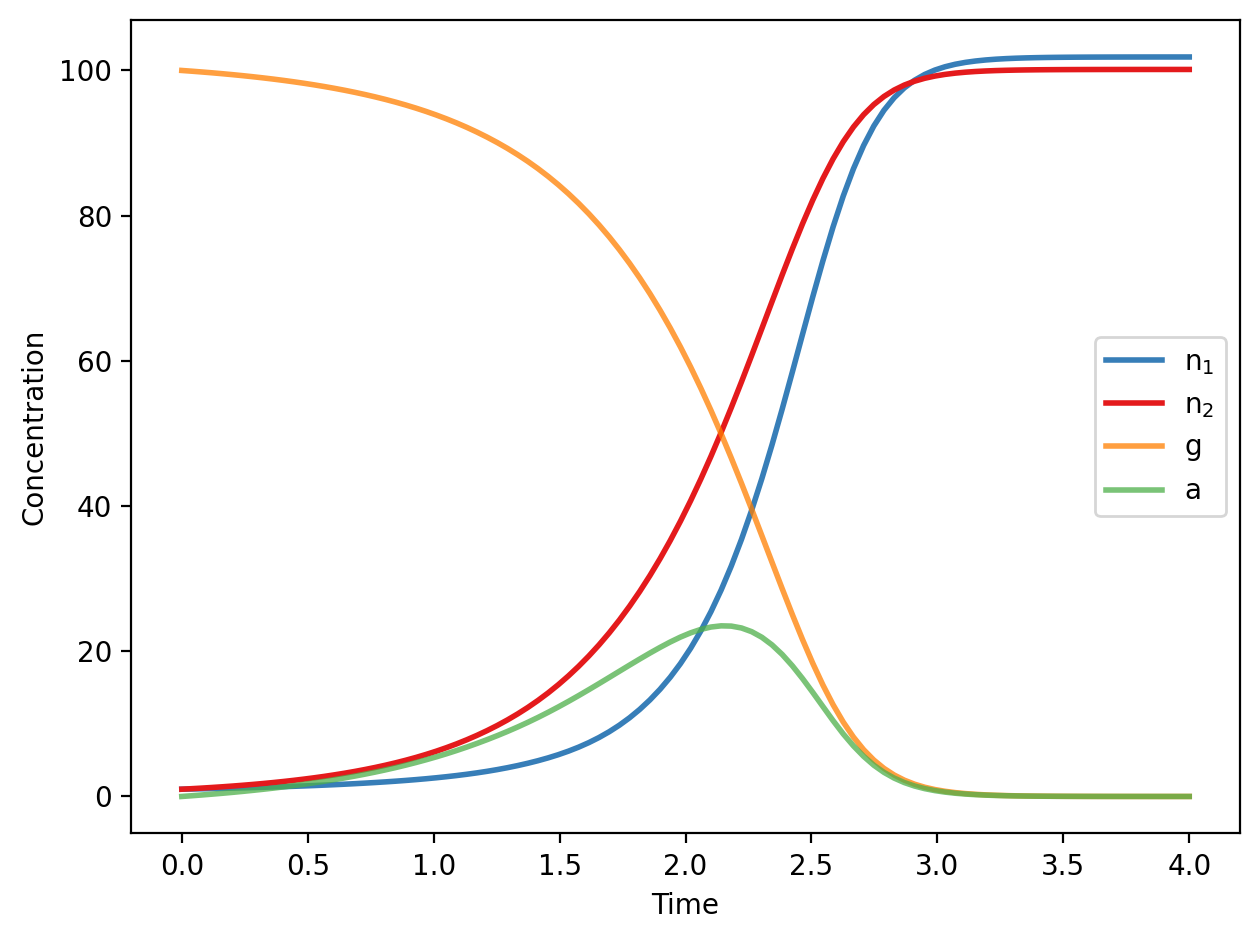

In [82]:
red, blue, green, purple, orange  = sns.color_palette('Set1', 5) ###

fig, ax = plt.subplots()

n1, n2, g, a = sol.y
ax.plot(t, n1, color=blue, label='$n_1$', lw=2)
ax.plot(t, n2, color=red, label='$n_2$', lw=2)
ax.plot(t, g, color=orange, label='$g$', alpha=0.75, lw=2)
ax.plot(t, a, color=green, label='$a$', alpha=0.75, lw=2)
ax.set(xlabel='Time', ylabel='Concentration')
ax.legend()
fig.tight_layout()

In the actual experiment described in the paper, after each growth cycle (of 4 or more hours, it doesn't matter as growth arrests after 4 hours), the population was diluted 100-fold, and new media was introduced. 

**Implement the function `growth_cycles` that runs such an experiment for `ncycles` cycles.** 
- The function should return the frequency `p` of strain 2 (the cross-feeding strain) at each cycle, such that $p(t)=\frac{n_2(t)}{n_1(t) + n_2(t)}$.
- The initial concentration of the strains at each cycle should be a `F`-fold dilution of the concentration at the end of the previous cycle. 
- You should decide the concentration of the two strains at the first cycle according to your choice in the previous exercise, but set strain 2 frequency to be `p0`.

In [77]:
def growth_cycles(p0, ncycles, F): ###
    cycles = np.arange(ncycles)
    p = np.empty(ncycles, dtype=float)
    p[0] = p0
    init = 2*(1-p0), 2*p0, 100, 0
    t = np.linspace(0, 4, 100)

    for cycle in range(1, ncycles):
        sol = solve_ivp(ode, (t.min(), t.max()), init, t_eval=t)
        n1, n2, _, _ = sol.y[:, -1]
        init = n1/F, n2/F, 100, 0
        p[cycle] = n2 / (n1 + n2)
    
    return p ###

**Reproduce Figure 3B**.

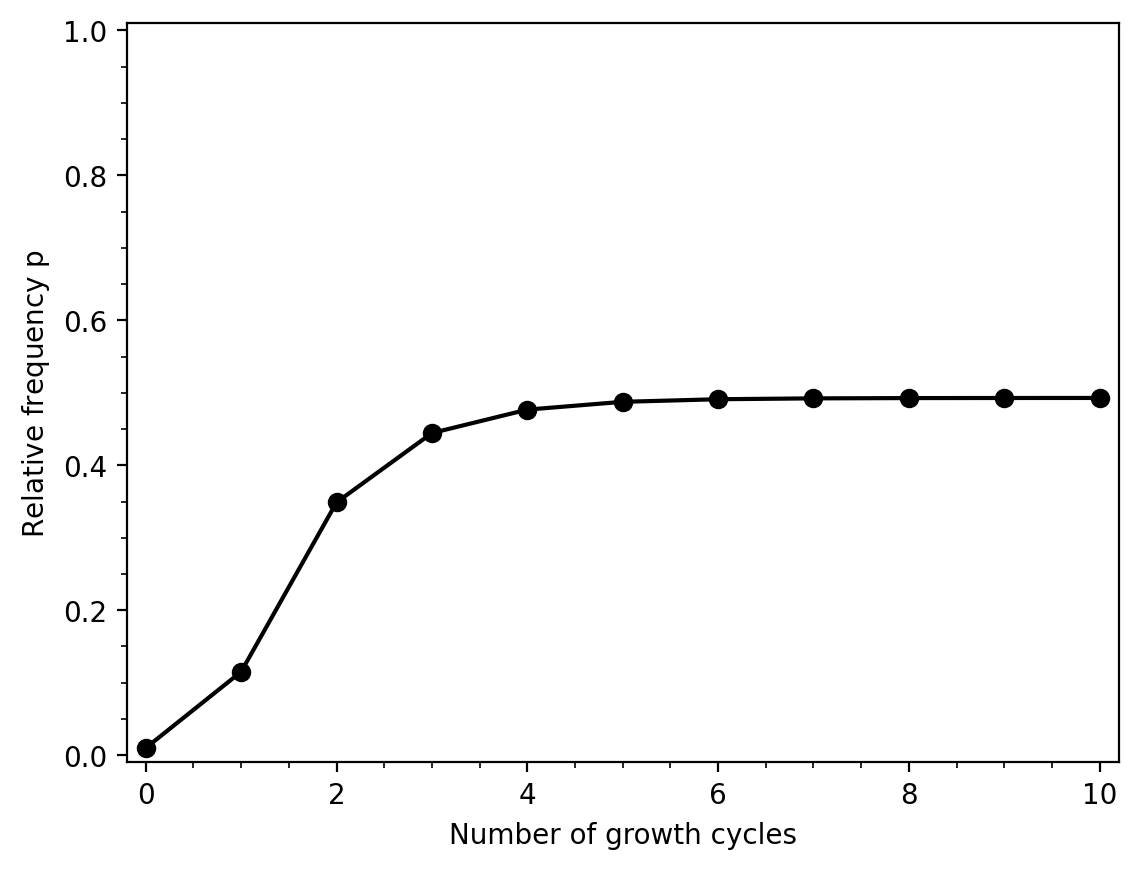

In [78]:
p = growth_cycles(0.01, 11, 100)

fig, ax = plt.subplots()
ax.plot(p, 'o-k')
ax.set_xlabel("Number of growth cycles")
ax.set_ylabel("Relative frequency $p$")
ax.set_ylim(-0.01, 1.01)
ax.set_xlim(-0.2, 10.2)
ax.minorticks_on();

# Ex 2: Metastasis of Malignant Tumors

This exercise follows an example from chapter 7 of Otto and Day (2007).

We will construct a model for the dynamics of the number of cancer cells lodged in the capillaries of an organ, $C$, and the number of cancer cells that have actually invaded that organ, $I$.

Suppose that cells are lost from the capillaries by dislodgement or death at a per capita rate $\delta_1$ and that they invade the organ from the capillaries at a per capita rate $\beta$. Once cells are in the organ they die at a per capita rate $\delta_2$, and the cancer cells replicate at a per capita rate $\rho$.

This gives the following euqations:
$$
\frac{dC}{dt} = -\delta_1 C - \beta C \\\\
\frac{dI}{dt} = \beta C - \delta_2 I + \rho I
$$

**Implement the ODE and plot its solution for two sets of parameter values.**

Use the parameter sets provided below and reproduce the figure.

In [131]:
def ode(t, x, δ1, δ2, β, ρ): ###
    C, I = x
    return np.array([
        -δ1 * C - β * C,
        β * C - δ2 * I + ρ * I
    ])

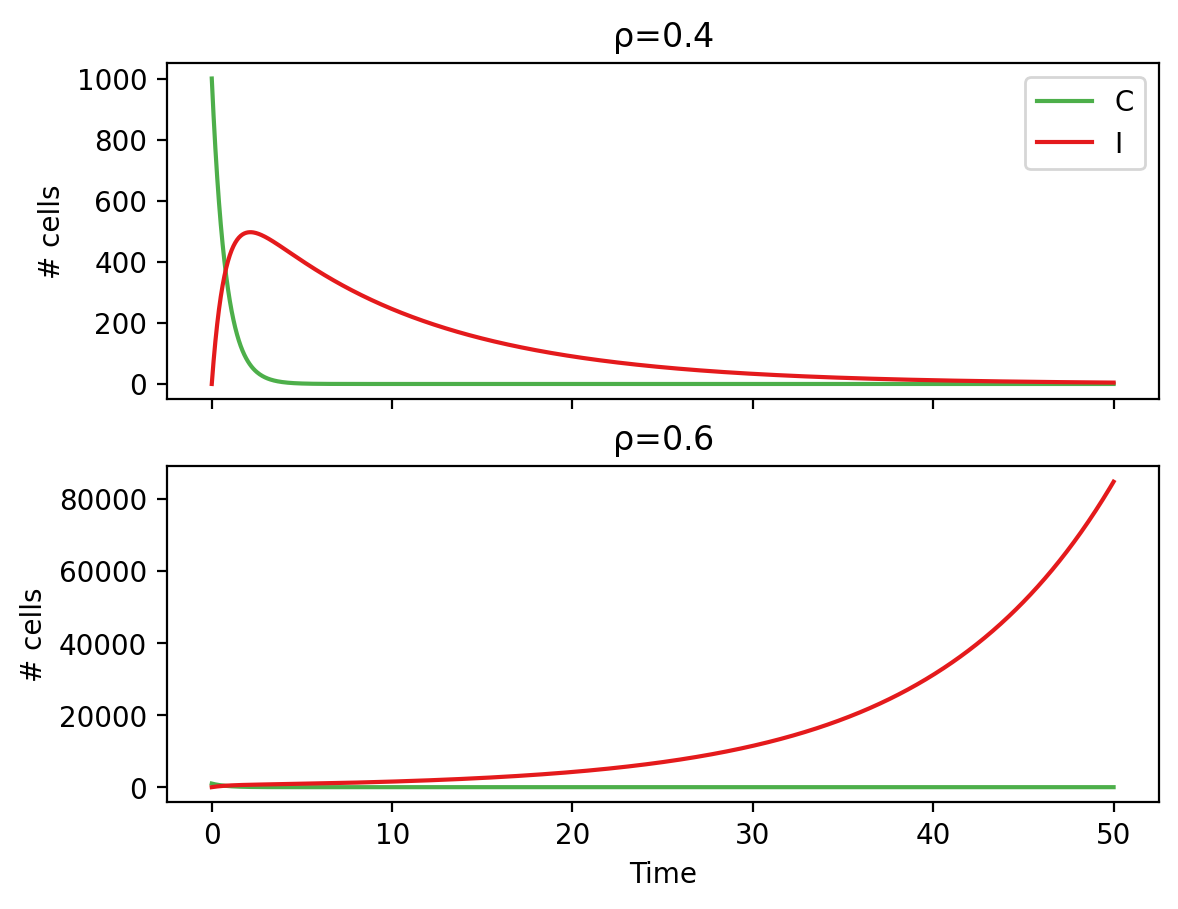

In [132]:
δ1, δ2, β, ρ = 0.5, 0.5, 0.8, 0.4 ###
ode1 = partial(ode, δ1=δ1, δ2=δ2, β=β, ρ=ρ) ###
δ1, δ2, β, ρ = 0.5, 0.5, 0.8, 0.6 ###
ode2 = partial(ode, δ1=δ1, δ2=δ2, β=β, ρ=ρ) ###

init = 1000, 0
t = np.linspace(0, 50, 1000)
fig, axes = plt.subplots(2, 1, sharex=True, sharey=False)
sol = solve_ivp(ode1, (t.min(), t.max()), init, t_eval=t)
C, I = sol.y
axes[0].plot(t, C, label='C', color=green)
axes[0].plot(t, I, label='I', color=red)
axes[0].set_title(r'$\rho$=0.4')

sol = solve_ivp(ode2, (t.min(), t.max()), init, t_eval=t)
C, I = sol.y
axes[1].plot(t, C, label='C', color=green)
axes[1].plot(t, I, label='I', color=red)
axes[1].set_title(r'$\rho$=0.6')

axes[1].set_xlabel('Time')
for i in range(2): axes[i].set_ylabel('# cells')
axes[0].legend();

We want to know if a new tumor will be able to take hold and grow or will it disappear?

**Find the only equilibrium** of this system. To do so, you can find the values of $C$ and $I$ that give $\frac{dC}{dt}=\frac{dI}{dt}=0$ (note that all parameters are positive).

**Test your equilibrium**: choose 1000 random choices of positive model parameters ($\delta_1$, $\delta_2$, $\beta$, and $\rho$) and check that indeed $\frac{dC}{dt}=\frac{dI}{dt}=0$ at the equiblrlium.

In [133]:
δ1, δ2, β, ρ = np.random.uniform(0, 1, size=(4, 1000)) ###
x_star = 0, 0
np.allclose(ode(0, x_star, δ1, δ2, β, ρ).T, x_star) ###

True

The single equilibrium doesn't provide the whole answer, because clearly for one of the above parameter sets the equilibrium is not reached -- it is unstable. 

**Find and describe the conditions for *local stability* of the equilibrium.**
Briefly, this requires that the real parts eigenvalues of the Jacobian evaluated at the equilibrium are negative, see a detalied explanation [here](../notebooks/stability.ipynb).

To solve this exercise, use *SymPy* to find the leading eigenvalue (largest eigenvalue) and print its value. 
The sign of this eigenvalue will determine the stability of the system.

SymPy notes:
- `sympy.symbols('x y z')` will create the symbols `x`, `y`, and `z`.
- `sympy.diff(y, x)` will return the derivative of `y` with respect to `x`.
- `sympy.Matrix` will take a list of symbolic expression and create a matrix from that list.
- `A.subs([(x, val1), (y, val2)]` will substitute `val1` and `val2` (numbers) into the symbols `x` and `y` in the expression `A`.
- `M.eigenvals()` will return the eigenvalues of matrix `M` as a dictionary: the keys are the eigenvalue experssions, the values are the eigenvalue multiplicities (which we can ignore here).

In [151]:
import sympy
sympy.init_printing()

In [152]:
δ1, δ2, β, ρ, C, I = sympy.symbols('δ1 δ2 β ρ C I')

dCdt = -δ1 * C - β * C
dIdt = β * C - δ2 * I + ρ * I
dCdt, dIdt

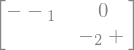

In [153]:
J = sympy.Matrix([
    [sympy.diff(dCdt, C), sympy.diff(dCdt, I)],
    [sympy.diff(dIdt, C), sympy.diff(dIdt, I)]
])
L = J.subs([(C, 0), (I, 0)])
L

In [195]:
eigs = list(L.eigenvals().keys())
λ = eigs[1]
λ

The following shows a visualization of the conditions for stability, where stability (and hence the demise of the tumor) occurs in the red region, wheras instability (and hence the growth of the tumor) occurs in the blue region.

Here, `λ` is a SymPy expression for the leading eigenvalue.

*You do not need to plot this figure*.

In [186]:
δ2_ = np.linspace(0, 1, 100)
ρ_ = np.linspace(0, 1, 100)
stability = np.array([[λ.subs([(δ2, δ2_[i]), (ρ, ρ_[j])]) for i in range(100)] for j in range(100)]).astype(float)

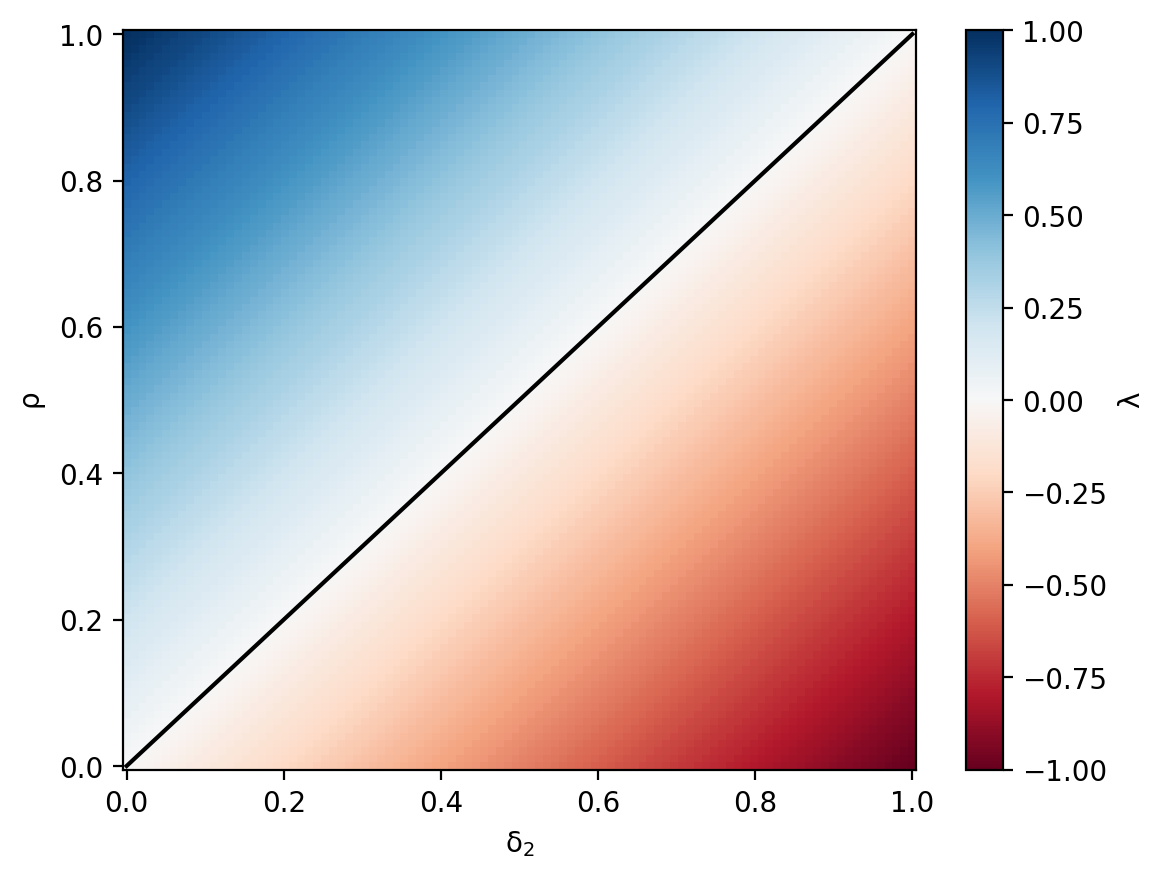

In [194]:
plt.pcolormesh(δ2_, ρ_, stability, cmap='RdBu')
plt.plot(δ2_, ρ_, color='k')
plt.colorbar(label='$\lambda$')
plt.xlabel(r'$\delta_2$')
plt.ylabel(r'$\rho$');

__end of assignment__